# Running statistical tests on RTR data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%matplotlib inline

In [2]:
rtr_data = pd.read_csv('rtr_clean.csv')

In [3]:
rtr_data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
rtr_data.head()

,age,body_type,bust_size,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,review_datetime,band_size,cup_size,review_text_word_count,review_summary_word_count
0,28.0,hourglass,34d,romper,fit,68.0,2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137.0,2016-04-20,34.0,d,39,3
1,36.0,straight & narrow,34b,gown,fit,66.0,153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132.0,2013-06-18,34.0,b,41,4
2,116.0,NaN,NaN,sheath,fit,64.0,1063761,10.0,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,NaN,2015-12-14,NaN,NaN,39,17
3,34.0,pear,34c,dress,fit,65.0,126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135.0,2014-02-12,34.0,c,83,8
4,27.0,athletic,34b,gown,fit,69.0,616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145.0,2016-09-26,34.0,b,111,7


## Sizes from the RentTheRunway site

The following categorical data is taken from [renttherunway.com](renttherunway.com) user setup page.

In [5]:
band_sizes = list(range(28, 50, 2))
cup_sizes = ['aa', 'a', 'b', 'c', 'd', 'dd', 'ddd/e', 'f', 'g', 'h', 'i', 'j']
rtr_bust_sizes = [str(band)+cup for band in band_sizes for cup in cup_sizes]
rtr_jean_sizes = list(range(24, 41))
rtr_dress_sizes = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, '24+']
rtr_body_types = ['apple', 'athletic', 'full bust', 'hourglass', 'pear', 'petite', 'straight & narrow']

## Reviewer sizes
(includes pants sizes as well, not just dress sizes)

In [6]:
rtr_data['size'].unique()

array([14, 12,  4,  8, 21,  1, 20,  2, 17, 16, 28, 36, 35, 24, 15,  5, 51,
       32, 23, 48, 45,  9, 13, 34, 39,  7, 25, 58, 26, 57, 29, 11,  0, 40,
        3, 33, 27, 43, 42, 19, 44, 54, 38, 10, 49, 52, 46,  6, 37, 22, 56,
       50, 41, 30, 55, 18], dtype=int64)

## Visualizing some of the data

We'll focus on dress data here since dresses are reviewed often and review ratings are likely to depend on garment category.

***
The following visualizations show mean dress rating grouped by size and body type. 
The vertical line on each bar are standard deviation for that category's data. 
The horizontal line is the mean rating for the given body type.

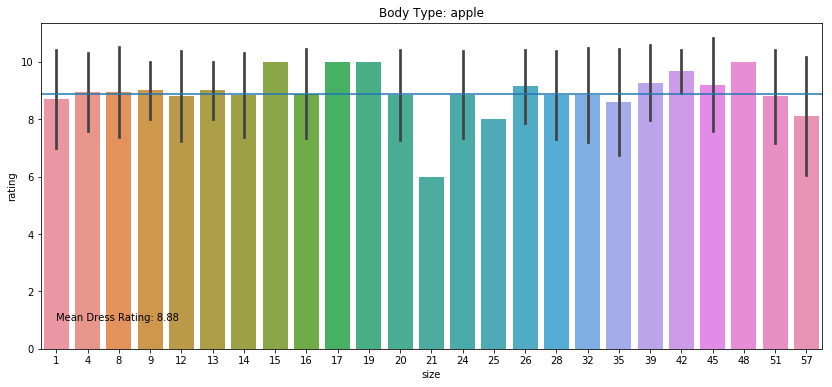

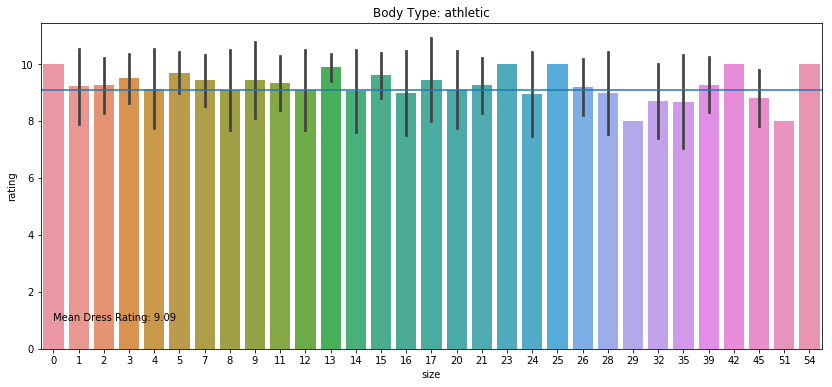

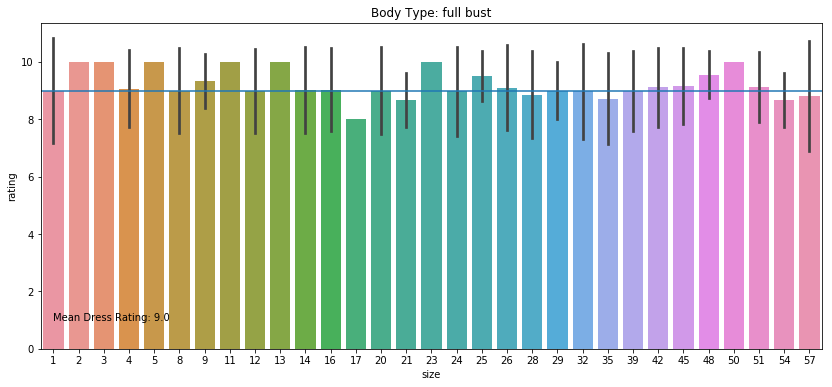

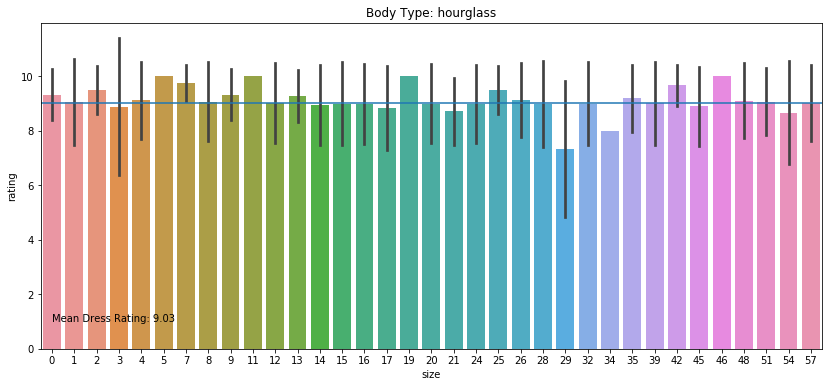

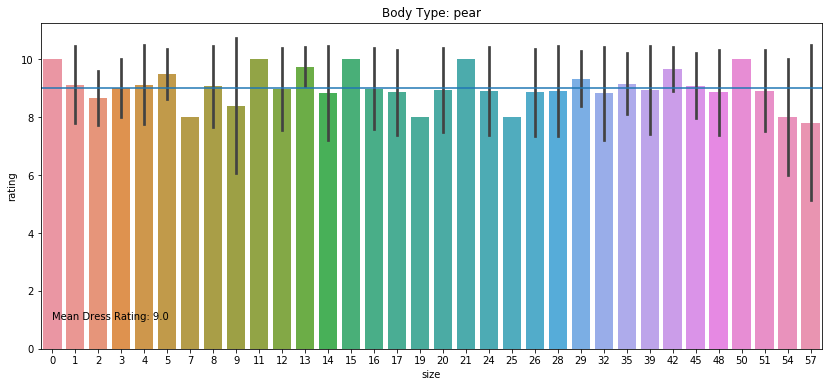

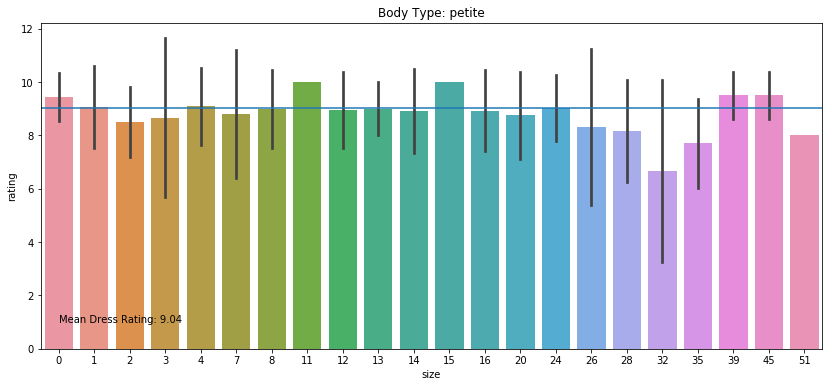

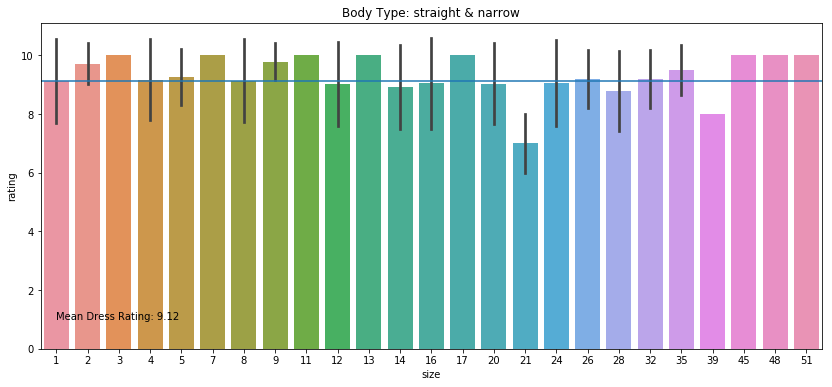

In [7]:
for bodytype in rtr_body_types:
    plt.figure(figsize=(14, 6))
    sns.barplot(x='size', 
                y='rating', 
                data=rtr_data.loc[(rtr_data.body_type==bodytype)&(rtr_data.category=='dress')], 
                ci='sd')
    plt.title('Body Type: '+bodytype)
    mean = rtr_data.loc[(rtr_data.body_type==bodytype)&(rtr_data.category=='dress')].rating.mean()
    plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,1))
    plt.axhline(y=mean)
    plt.show()

It is hard to identify any trends in this visualization. 
Let's move on to another visualization.
***

The following visualizations show mean dress rating grouped by cup size and body type. 
The vertical line on each bar are standard deviation for that category's data. 
The horizontal line is the mean rating for the given cup size.

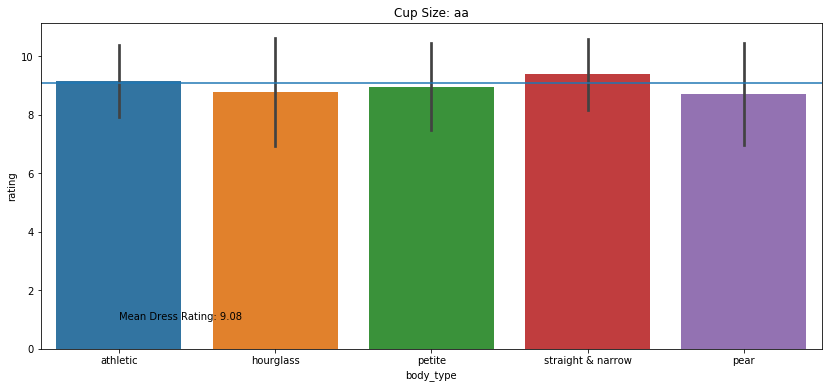

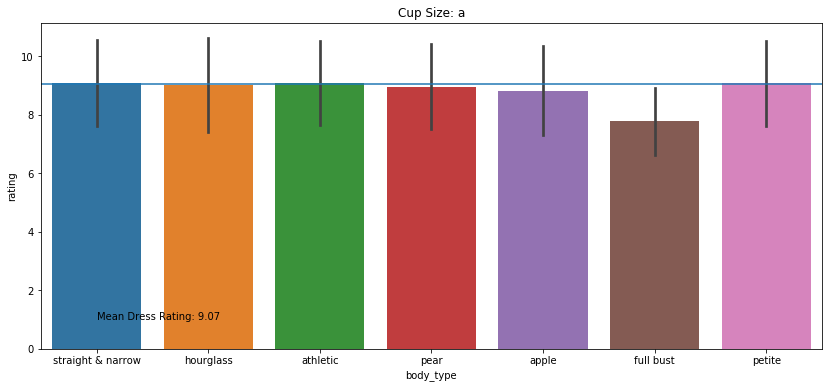

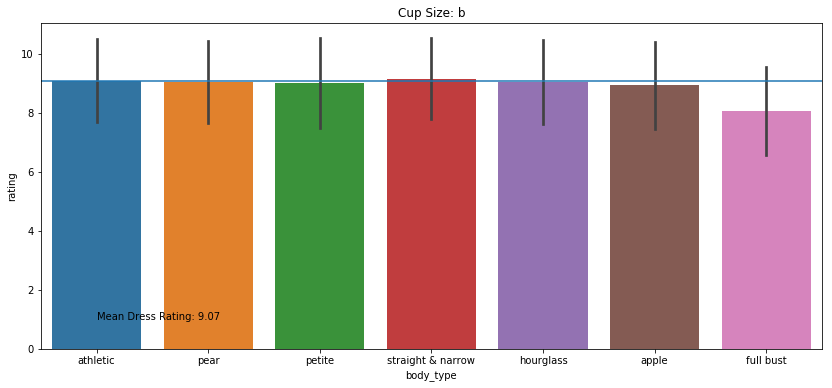

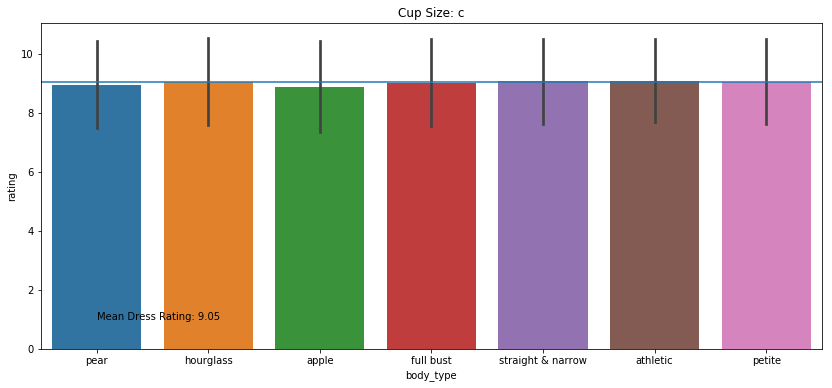

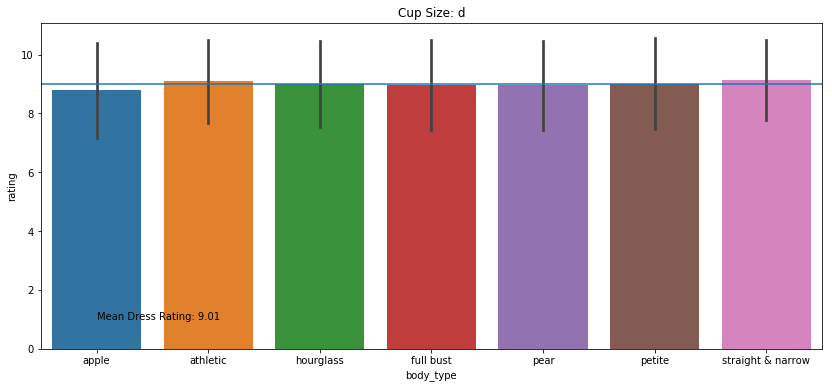

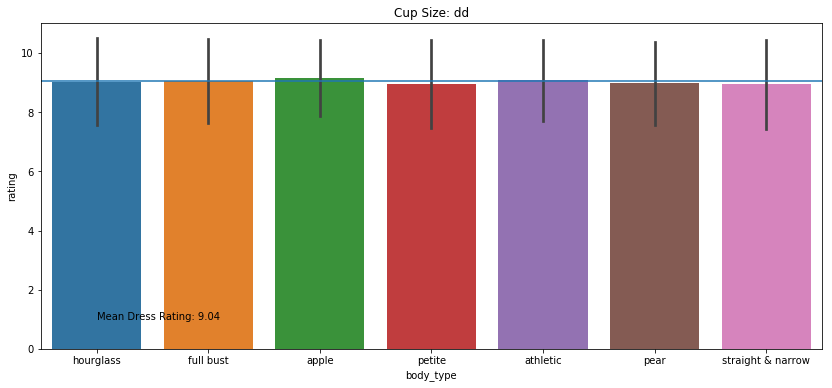

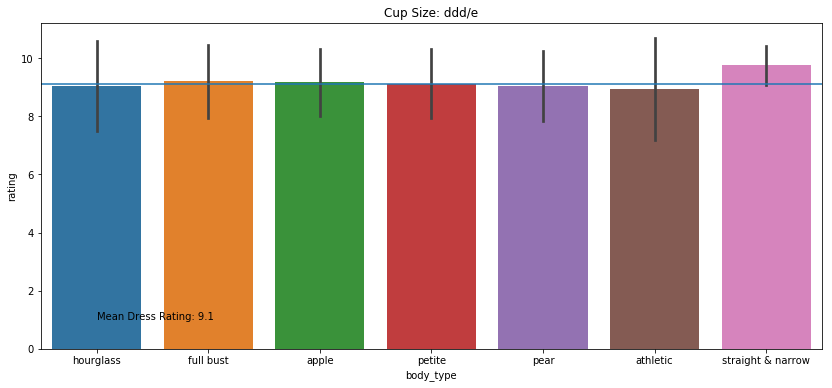

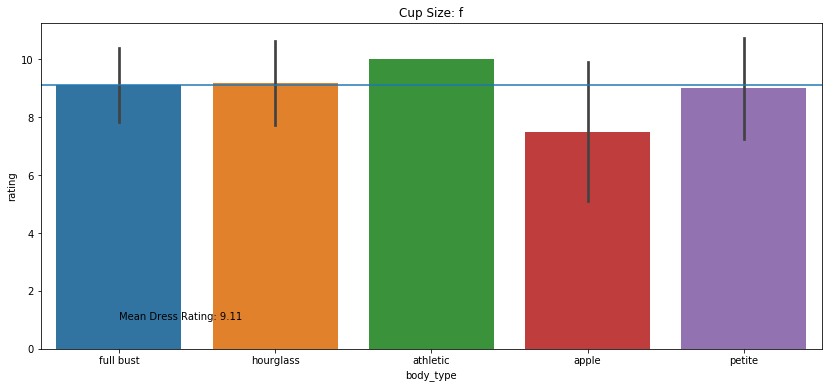

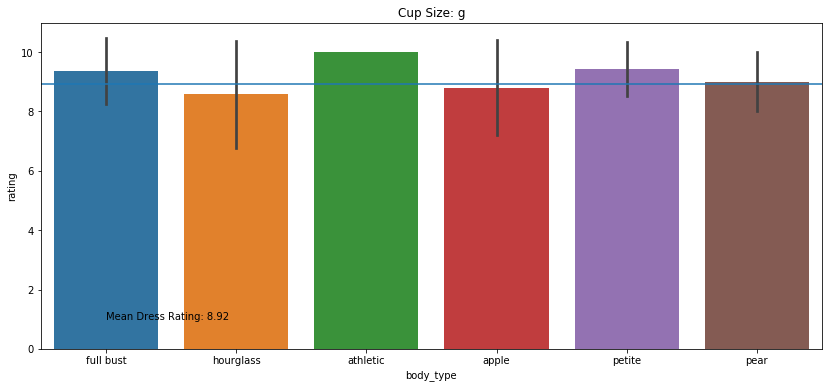

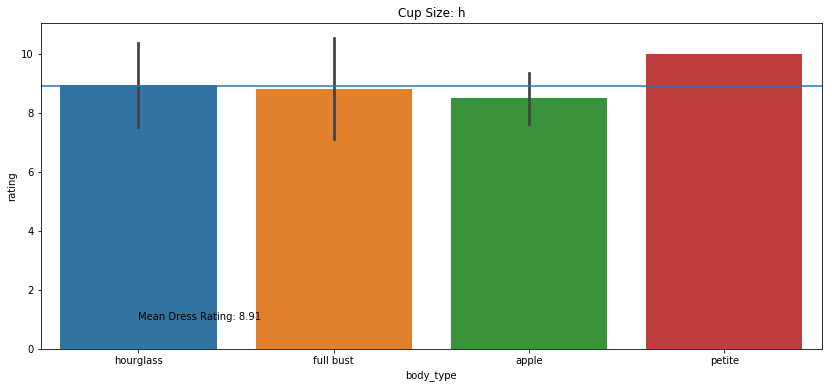

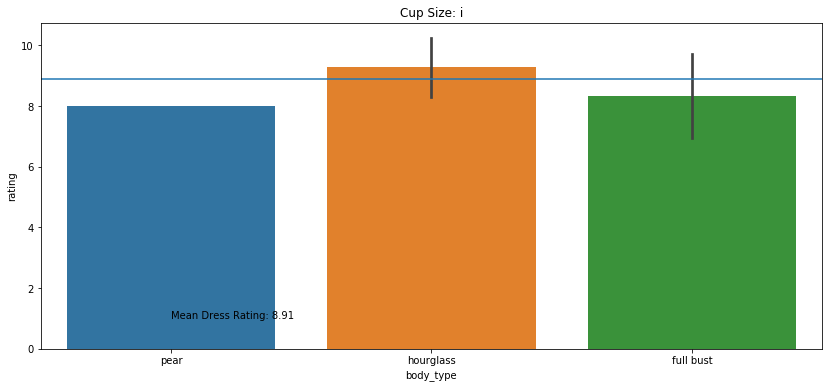

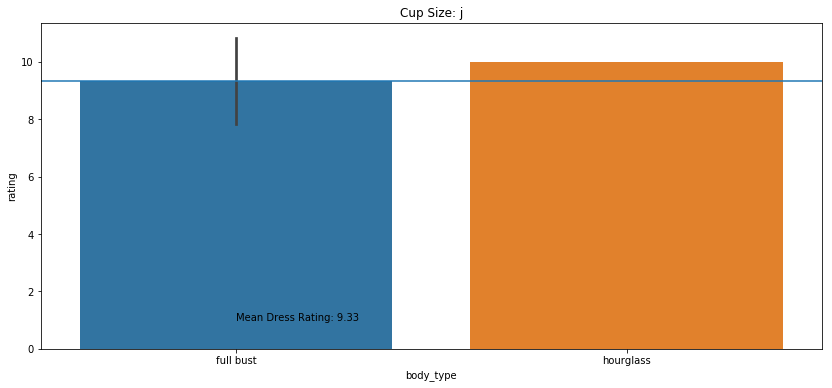

In [8]:
for cup in cup_sizes:
    plt.figure(figsize=(14, 6))
    sns.barplot(x='body_type', 
                y='rating', 
                data=rtr_data.loc[(rtr_data.cup_size==cup)&(rtr_data.category=='dress')], 
                ci='sd')
    plt.title('Cup Size: '+cup)
    mean = rtr_data.loc[(rtr_data.cup_size==cup)&(rtr_data.category=='dress')].rating.mean()
    plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,1))
    plt.axhline(y=mean)
    plt.show()

So if the reviewer self-described as __full bust__ and had a cup size of $b$ or smaller, then they seem more likely to rate a dress lower than average. 
In the other direction, if the reviewer self-describes as __straight & narrow__ with a cup size of $ddd/e$, then they seem more likely to rate a dress higher than average.

In [9]:
print('Number of Reviews:')
print('full bust with cup size b or smaller = ', 
      len(rtr_data.loc[((rtr_data.cup_size=='a')|(rtr_data.cup_size=='b'))&(rtr_data.category=='dress')&(rtr_data.body_type=='full bust')]), '\n'
      'straight & narrow with cup size ddd/e = ', 
      len(rtr_data.loc[(rtr_data.cup_size=='ddd/e')&(rtr_data.category=='dress')&(rtr_data.body_type=='straight & narrow')]))

Number of Reviews:
full bust with cup size b or smaller =  39 
straight & narrow with cup size ddd/e =  8


There aren't a lot of data that match the above criteria, so we'll move on to another idea.
***

### Did reviewers with different body types buy the same dresses? If so, how did ratings change?

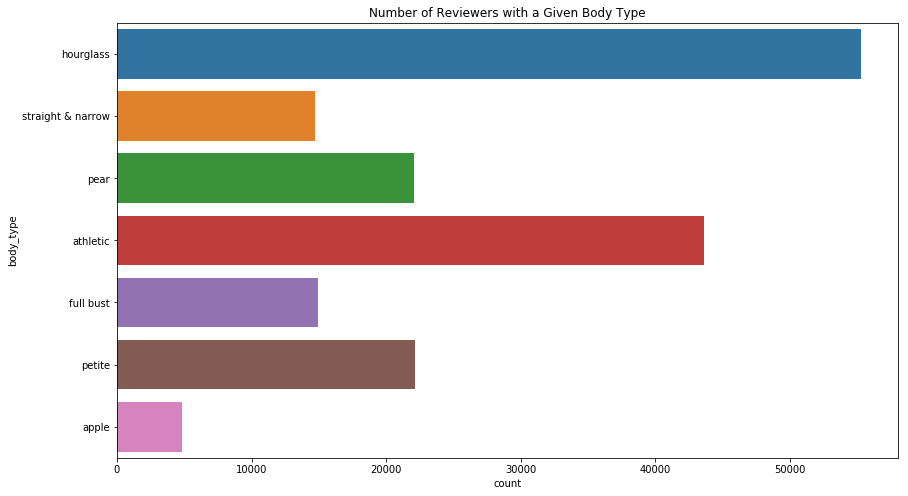

In [10]:
plt.figure(figsize=(14,8))
sns.countplot(data=rtr_data, y='body_type')
plt.title('Number of Reviewers with a Given Body Type')
plt.show()

A lot of reviewers self-describe as __hourglass__ or __athletic__, relatively few self-describe as __apple__

In [11]:
print(len(rtr_data.item_id.unique()), len(rtr_data.loc[rtr_data.category=='dress'].item_id.unique()))

5850 2615


There are 5850 distinct items, 2615 of which are dresses

In [12]:
rtr_data.loc[rtr_data.category=='dress'].item_id.value_counts().head()

126335    2239
174086    1724
136110    1196
172027     984
130259     914
Name: item_id, dtype: int64

In [13]:
top_5_most_reviewed_dresses = list(rtr_data.loc[rtr_data.category=='dress'].item_id.value_counts().head().index)
top_5_most_reviewed_dresses

[126335, 174086, 136110, 172027, 130259]

In [14]:
rtr_data.dropna(axis=0, subset=['rating'], inplace=True)

In [15]:
for dress in top_5_most_reviewed_dresses:
    print(rtr_data.loc[rtr_data.item_id==dress].rating.describe())

count    2229.000000
mean        8.960072
std         1.500665
min         2.000000
25%         8.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64
count    1724.000000
mean        9.013921
std         1.365283
min         2.000000
25%         8.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64
count    1196.000000
mean        9.081940
std         1.360522
min         2.000000
25%         8.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64
count    984.000000
mean       8.587398
std        1.683044
min        2.000000
25%        8.000000
50%        8.000000
75%       10.000000
max       10.000000
Name: rating, dtype: float64
count    913.000000
mean       8.768894
std        1.536199
min        2.000000
25%        8.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: rating, dtype: float64


The top 5 most reviewed dresses have pretty high averages. 
Lets see how their ratings are related to body type.

***
***
_Aside_:
    What are the other most often reviewed garment types?

In [16]:
top_5_most_reviewed_garments = list(rtr_data.item_id.value_counts().head().index)
top_5_most_reviewed_garments

[126335, 174086, 123793, 132738, 145906]

In [17]:
for garment in top_5_most_reviewed_garments:
    print(rtr_data.loc[rtr_data.item_id==garment].groupby('item_id').first().category)

item_id
126335    dress
Name: category, dtype: object
item_id
174086    dress
Name: category, dtype: object
item_id
123793    gown
Name: category, dtype: object
item_id
132738    gown
Name: category, dtype: object
item_id
145906    gown
Name: category, dtype: object


The other most often reviewed garment types are gowns. 
We could merge this with dress info, but for ease of understanding, we will keep this distinct and focus on garments labelled as dresses.
***
***

Now, 
### Did user's with different body types review the same dresses? If so, how did ratings change?

In [18]:
for dress in top_5_most_reviewed_dresses:
    for bodytype in rtr_body_types:
        print(f'There are {len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)])} users with {bodytype} body type and who reviewed dress {dress}.')

There are 114 users with apple body type and who reviewed dress 126335.
There are 373 users with athletic body type and who reviewed dress 126335.
There are 292 users with full bust body type and who reviewed dress 126335.
There are 842 users with hourglass body type and who reviewed dress 126335.
There are 329 users with pear body type and who reviewed dress 126335.
There are 126 users with petite body type and who reviewed dress 126335.
There are 78 users with straight & narrow body type and who reviewed dress 126335.
There are 49 users with apple body type and who reviewed dress 174086.
There are 385 users with athletic body type and who reviewed dress 174086.
There are 185 users with full bust body type and who reviewed dress 174086.
There are 484 users with hourglass body type and who reviewed dress 174086.
There are 194 users with pear body type and who reviewed dress 174086.
There are 279 users with petite body type and who reviewed dress 174086.
There are 97 users with straight

Self-described body types of __athletic__ or __hourglass__ consistently have more reviews for each dress. 

Lets determine if the ratings for each body type given a particular dress are normally distributed.

In [19]:
for dress in top_5_most_reviewed_dresses:
    for bodytype in rtr_body_types:
        k2, p = stats.normaltest(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)].rating)
        if p>0.05:
            print(dress, bodytype, 'data are normally distributed.')

C:\Users\cliff\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


172027 pear data are normally distributed.
130259 straight & narrow data are normally distributed.


Most ratings are not normally distributed, so we will use resampling (bootstrapping) to create normal sampling distribtions for __athletic__ and __hourglass__ body types.

In [90]:
def resampling_func(item, bodytype, n, size):
    df = rtr_data.loc[(rtr_data.item_id==item)&(rtr_data.body_type==bodytype)]

    resamples = []
    for i in range(n):
        resamples.append(np.random.choice(df.rating, size=size))
    
    means = [resamples[i].mean() for i in range(n)]
    k2, p = stats.normaltest(means)
    if p<0.01:
        print('Increase "n" or "size" to get a distribution closer to normal')
        sns.distplot(means)
        plt.show()
        return p
    else:
        return means

We may need to run the following cell more than once until there is no comment to increase "n" or "size".

In [91]:
new_samples = {}
for dress in top_5_most_reviewed_dresses:
    for bodytype in ['athletic', 'hourglass']:
        new_samples[(dress, bodytype)] = resampling_func(dress, bodytype, 10000, 1000)

### $H_0$: For the given dress, the mean rating for reviewers with __athletic__ body type is equal to the mean rating for reviewers with __hourglass__ body type ($\alpha=0.05$).

### $H_1$: For the given dress, the mean rating for reviewers with __athletic__ body type is not equal to the mean rating for reviewers with __hourglass__ body type.

In [95]:
for dress in top_5_most_reviewed_dresses:
    athletic_samples = np.random.choice(new_samples[(dress, 'athletic')], size=100)
    hourglass_samples = np.random.choice(new_samples[(dress, 'hourglass')], size=100)
    result = stats.ttest_ind(athletic_samples, hourglass_samples, equal_var=False)
    print(dress)
    if result[1]>=0.05:
        print('We fail to reject the null hypothesis:')
        print(f'p_value {result[1]}\n')
    else:
        print('We reject the null hypothesis:')
        print(f'p_value {result[1]}\n')

126335
We reject the null hypothesis:
p_value 0.0014553000289905904

174086
We reject the null hypothesis:
p_value 8.481993589865608e-15

136110
We reject the null hypothesis:
p_value 3.905662760307049e-56

172027
We fail to reject the null hypothesis:
p_value 0.8917069053180613

130259
We reject the null hypothesis:
p_value 2.6405515155835453e-24



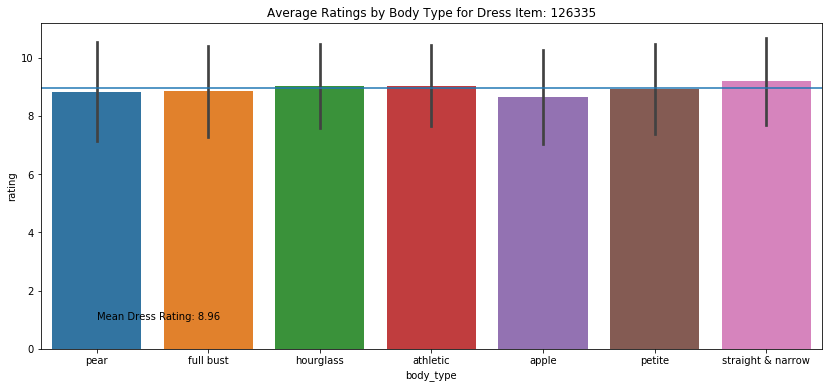

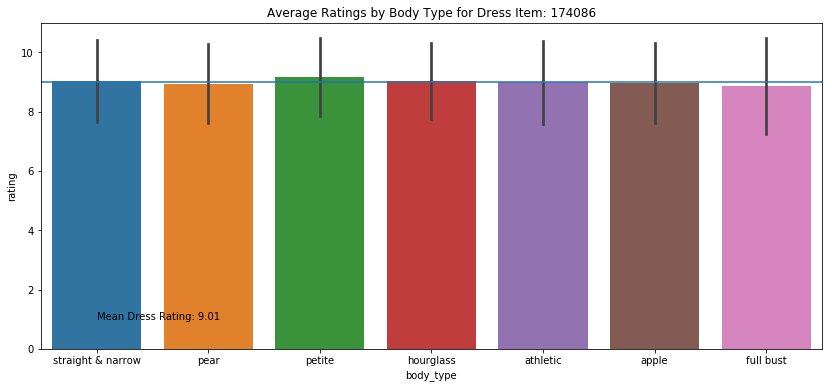

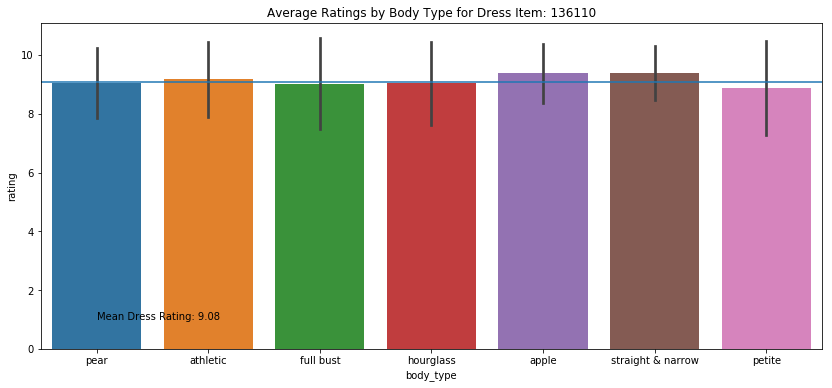

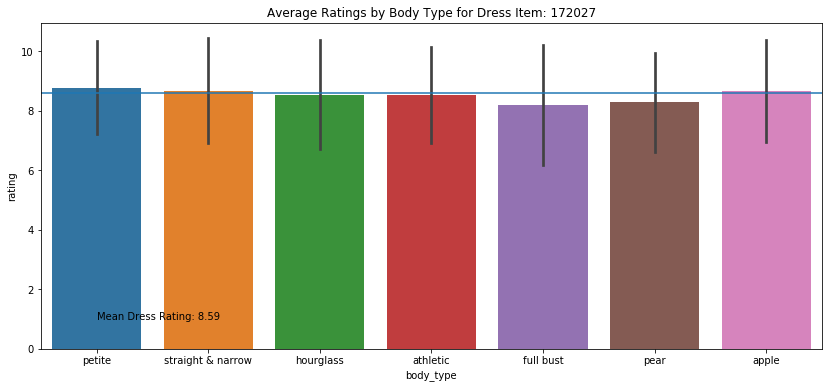

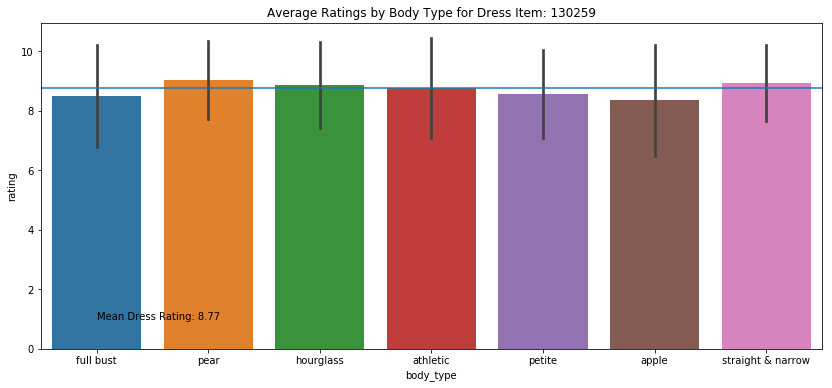

In [23]:
for dress in top_5_most_reviewed_dresses:
    plt.figure(figsize=(14, 6))
    sns.barplot(x='body_type', 
                y='rating', 
                data=rtr_data.loc[(rtr_data.item_id==dress)], 
                ci='sd')
    plt.title('Average Ratings by Body Type for Dress Item: '+str(dress))
    mean = rtr_data.loc[(rtr_data.item_id==dress)].rating.mean()
    plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,1))
    plt.axhline(y=mean)
    plt.show()

In [96]:
top_5_most_reviewed_dresses

[126335, 174086, 136110, 172027, 130259]

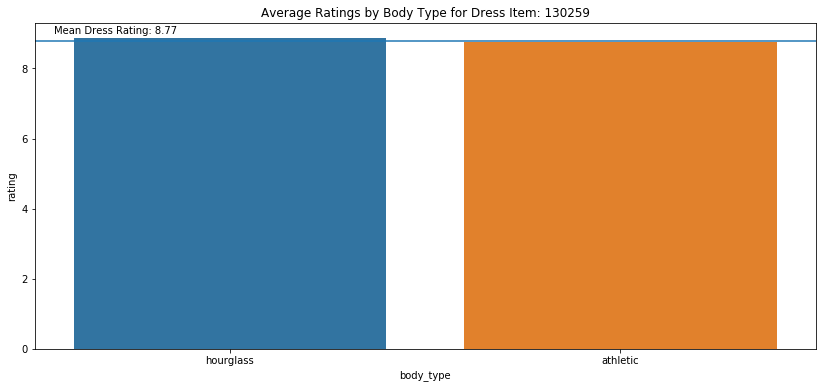

In [122]:
plt.figure(figsize=(14, 6))
sns.barplot(x='body_type', 
            y='rating', 
            data=rtr_data.loc[(rtr_data.item_id==130259)&(rtr_data.body_type.isin(['athletic', 'hourglass']))], 
            ci=False)
plt.title('Average Ratings by Body Type for Dress Item: '+str(130259))
mean = rtr_data.loc[(rtr_data.item_id==130259)].rating.mean()
plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (-0.45,9))
plt.axhline(y=mean)
# plt.savefig('dress_130259_avg_rating')
plt.show()

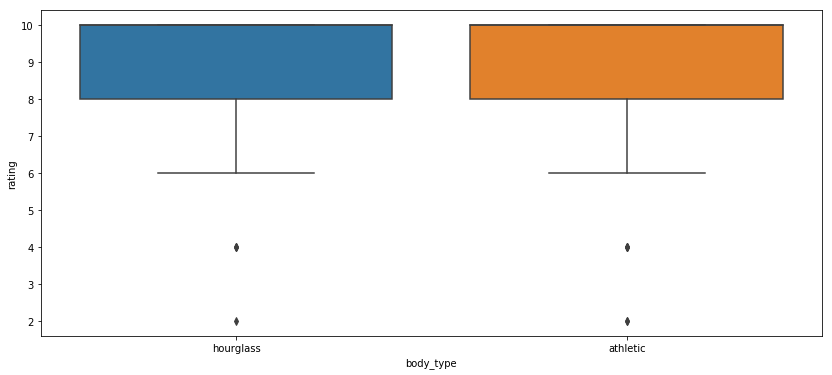

In [127]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='body_type', 
            y='rating', 
            data=rtr_data.loc[(rtr_data.item_id==130259)&(rtr_data.body_type.isin(['athletic', 'hourglass']))])

In [134]:
def calc_cohens_d(dress):
    return (rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type.isin(['athletic']))].rating.mean()-rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type.isin(['hourglass']))].rating.mean())/rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type.isin(['athletic', 'hourglass']))].rating.std()

for dress in top_5_most_reviewed_dresses:
    print(dress, calc_cohens_d(dress))

126335 0.0165891784260378
174086 -0.03986442726209547
136110 0.09557701615454876
172027 -0.004395699558372747
130259 -0.058573390265457013


It looks like there are some differences in the average means given body type depending on the dress. 
If there are enough values in each of these categories, we would like to use a two sample $t$ test to compare the highest and lowest average ratings given body type.

Unfortunately, not all of the samples have a large $n$. 
In fact, some have a downright small $n$.
- There are 26 users with straight & narrow body type and who reviewed dress 130259.
- There are 12 users with apple body type and who reviewed dress 172027.
    
We'll run a proportions test on rating higher than 8 instead!

For each sample we'll need to check that $n\cdot p>5$ and $n\cdot (1-p)>5$ for all samples involved.

In [24]:
for dress in top_5_most_reviewed_dresses:
    for bodytype in rtr_body_types:
        n = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)])
        p = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)&(rtr_data.rating>8)])/n
        if n*p<=5 or n*(1-p)<=5:
            print(f'Users with {bodytype} body type who reviewed dress {dress}: np={n*p}, n(1-p)={n*(1-p)}.')

So each sample is viable to compare with a proportions test!
Let's compare the highest and lowest proportion of higher than 8 average rating for each dress.

In [25]:
extreme_ratings_proportions = {}
for dress in top_5_most_reviewed_dresses:
    ratings = []
    for bodytype in rtr_body_types:
        n = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)])
        x = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)&(rtr_data.rating>8)])
        p = x/n
        ratings.append({'body_type':bodytype, 'x':x, 'n':n, 'p':p})
    ratings = sorted(ratings, key=lambda rating: rating['p'])
    total_n = len(rtr_data.loc[(rtr_data.item_id==dress)])
    total_p = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.rating>8)])/total_n 
    extreme_ratings_proportions[dress] = (total_p, ratings[0], ratings[-1])
    
extreme_ratings_proportions

{126335: (0.5993719156572453,
  {'body_type': 'apple', 'x': 56, 'n': 114, 'p': 0.49122807017543857},
  {'body_type': 'straight & narrow',
   'x': 54,
   'n': 78,
   'p': 0.6923076923076923}),
 174086: (0.5945475638051044,
  {'body_type': 'pear', 'x': 107, 'n': 194, 'p': 0.5515463917525774},
  {'body_type': 'petite', 'x': 184, 'n': 279, 'p': 0.6594982078853047}),
 136110: (0.6229096989966555,
  {'body_type': 'pear', 'x': 112, 'n': 194, 'p': 0.5773195876288659},
  {'body_type': 'apple', 'x': 37, 'n': 52, 'p': 0.7115384615384616}),
 172027: (0.4817073170731707,
  {'body_type': 'full bust', 'x': 15, 'n': 39, 'p': 0.38461538461538464},
  {'body_type': 'straight & narrow',
   'x': 47,
   'n': 88,
   'p': 0.5340909090909091}),
 130259: (0.5213581599123768,
  {'body_type': 'petite', 'x': 20, 'n': 47, 'p': 0.425531914893617},
  {'body_type': 'pear', 'x': 82, 'n': 138, 'p': 0.5942028985507246})}

### $H_0$: Given a dress, the proportion of ratings over 8 for body type x is equal to the proportion of reviews over 8 overall ($\alpha=0.05$).

In [32]:
for dress in top_5_most_reviewed_dresses:
    p = extreme_ratings_proportions[dress][0]
    
    # Binomial test that the least proportions is statiscally lower than the population proportion
    x = extreme_ratings_proportions[dress][1]['x']
    n = extreme_ratings_proportions[dress][1]['n']
    body_type = extreme_ratings_proportions[dress][1]['body_type']
    p_value = stats.binom_test(x=x, n=n, p=p, alternative='less')
    if p_value>=0.05:
        print('We fail to reject the null hypothesis:')
        print(f'The proportion of body type {body_type} rating dress {dress} less than average.\n    p_value {p_value}\n')
    else:
        print('We reject the null hypothesis:')
        print(f'Alternative hypothesis: The proportion of body type {body_type} rating dress {dress} less than average.\n    p_value {p_value}\n')
    
    # Binomial test that the least proportions is statiscally lower than the population proportion
    x = extreme_ratings_proportions[dress][2]['x']
    n = extreme_ratings_proportions[dress][2]['n']
    body_type = extreme_ratings_proportions[dress][2]['body_type']
    p_value = stats.binom_test(x=x, n=n, p=p, alternative='greater')
    if p_value>=0.05:
        print('We fail to reject the null hypothesis:')
        print(f'The proportion of body type {body_type} rating dress {dress} greater than average.\n    p_value {p_value}\n')
    else:
        print('We reject the null hypothesis:')
        print(f'Alternative hypothesis: The proportion of body type {body_type} rating dress {dress} greater than average.\n    p_value {p_value}\n')

We reject the null hypotheseis:
the proportion of body type apple rating dress 126335 less than average.
    p_value 0.01247973105667982

We fail to reject the null hypotheseis:
the proportion of body type straight & narrow rating dress 126335 greater than average.
    p_value 0.05780285778346853

We fail to reject the null hypotheseis:
the proportion of body type pear rating dress 174086 less than average.
    p_value 0.12599680553470252

We reject the null hypotheseis:
the proportion of body type petite rating dress 174086 greater than average.
    p_value 0.015179002157341324

We fail to reject the null hypotheseis:
the proportion of body type pear rating dress 136110 less than average.
    p_value 0.10872895175963643

We fail to reject the null hypotheseis:
the proportion of body type apple rating dress 136110 greater than average.
    p_value 0.1187578766010133

We fail to reject the null hypotheseis:
the proportion of body type full bust rating dress 172027 less than average.
   

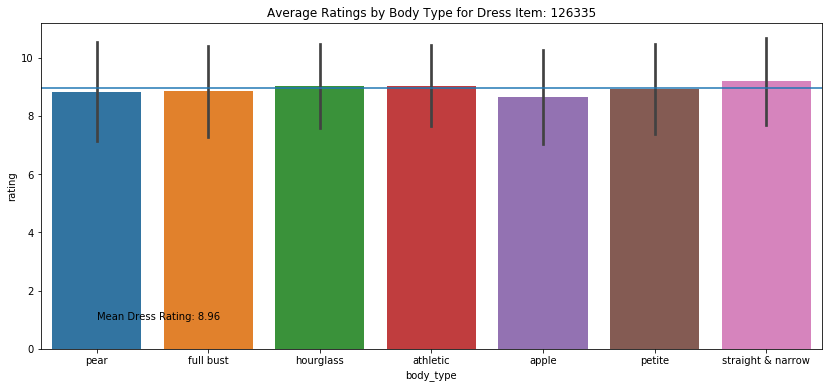

In [36]:
plt.figure(figsize=(14, 6))
sns.barplot(x='body_type', 
            y='rating', 
            data=rtr_data.loc[(rtr_data.item_id==126335)], 
            ci='sd')
plt.title('Average Ratings by Body Type for Dress Item: '+str(126335))
mean = rtr_data.loc[(rtr_data.item_id==126335)].rating.mean()
plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,1))
plt.axhline(y=mean)
plt.savefig('dress_126335_bodytype_ratings')
plt.show()

In [ ]:
rtr_data['high_rating'] = rtr_data.rating.apply(lambda x: x>8)

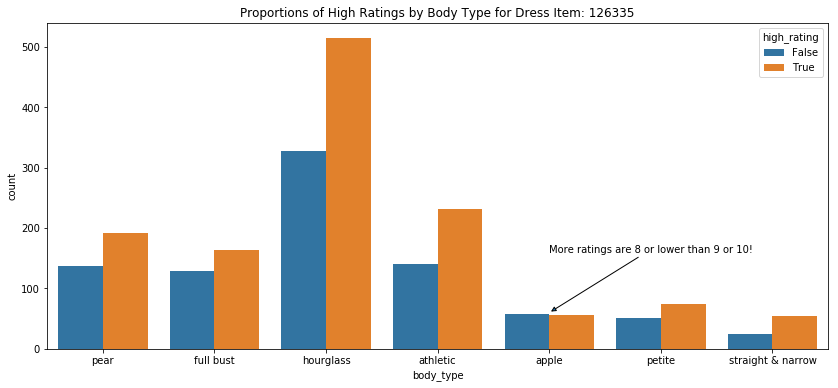

In [60]:
plt.figure(figsize=(14, 6))
sns.countplot(x='body_type', 
              data=rtr_data.loc[(rtr_data.item_id==126335)], 
              hue='high_rating')
plt.title('Proportions of High Ratings by Body Type for Dress Item: '+str(126335))
plt.annotate('More ratings are 8 or lower than 9 or 10!', 
             xy=(4,60), 
             xytext=(4,160), 
             arrowprops={'arrowstyle':'-|>'})
plt.savefig('dress_126335_high_ratings_proportions')
plt.show()

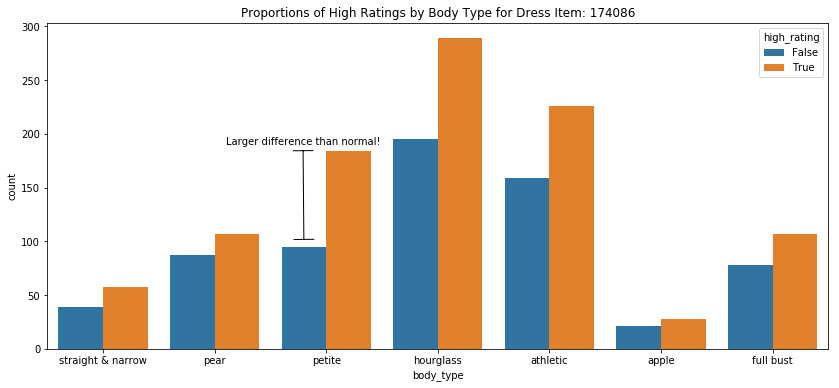

In [66]:
plt.figure(figsize=(14, 6))
sns.countplot(x='body_type', 
              data=rtr_data.loc[(rtr_data.item_id==174086)], 
              hue='high_rating')
plt.title('Proportions of High Ratings by Body Type for Dress Item: '+str(174086))
plt.annotate('Larger difference than normal!', 
             xy=(1.8,100), 
             xytext=(1.1,190), 
             arrowprops={'arrowstyle':'|-|'})
plt.savefig('dress_174086_high_ratings_proportions')
plt.show()

## Did a reviewer's body change over time?

In [27]:
rtr_users = rtr_data.groupby('user_id').count()

changed_users = []
for user in list(rtr_users.loc[rtr_users.review_date>1].index.values):
    total = len(rtr_data.loc[rtr_data.user_id==user])
    same = rtr_data.loc[rtr_data.user_id==user].duplicated(['bust_size', 'size', 'height'], keep=False).sum()
    if total-same>0:
        changed_users.append((user, total-same))

len(changed_users)

22977

***
## How many of each self-described body type are there?

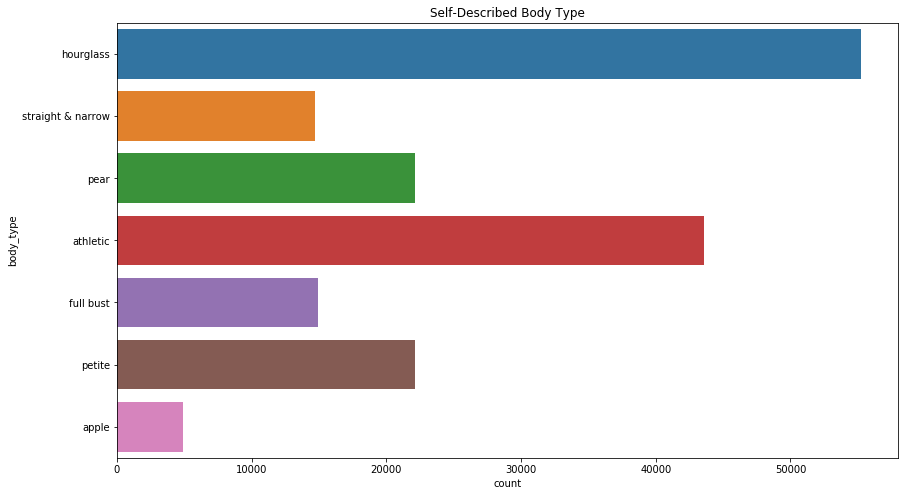

In [33]:
plt.figure(figsize=(14,8))
sns.countplot(data=rtr_data, y='body_type')
plt.title('Self-Described Body Type')
plt.show()

Looks like a lot of reviewers self-describe as hourglass. 
We don't have waist or hip measurements in this data, but we do have ```band_size```, ```cup```, and ```weight```... maybe we can see if there is a relationship between these (again self-describd) variables and the ```body_type```.

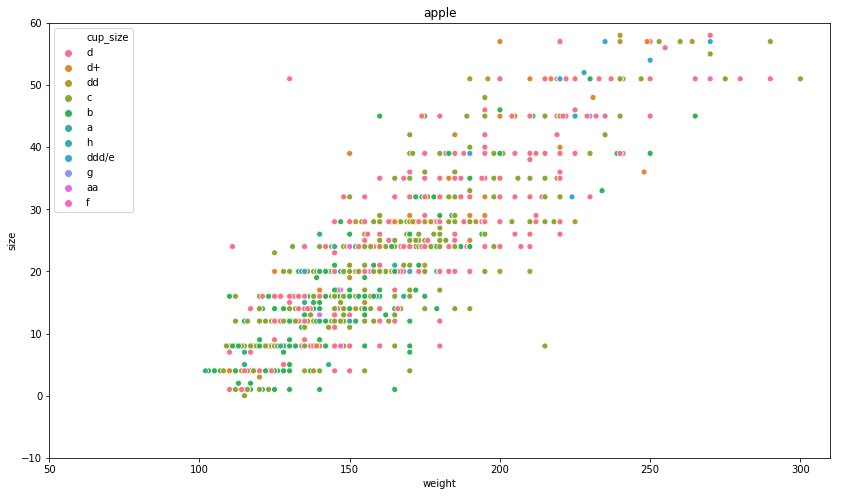

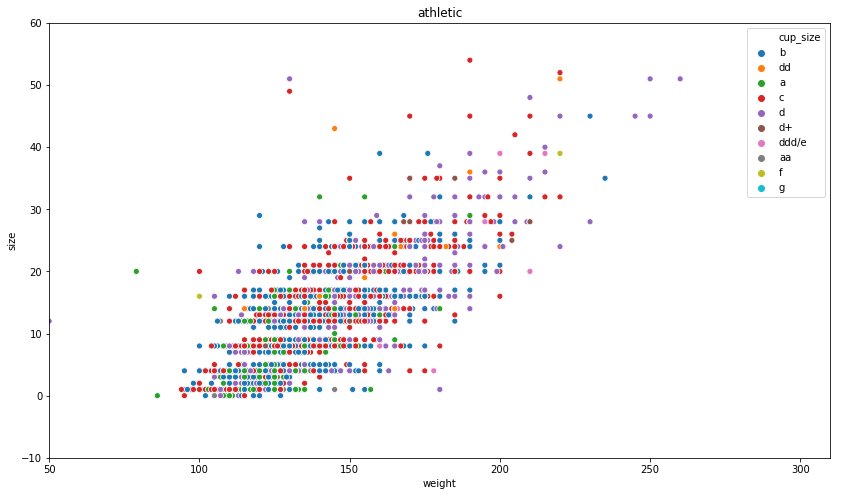

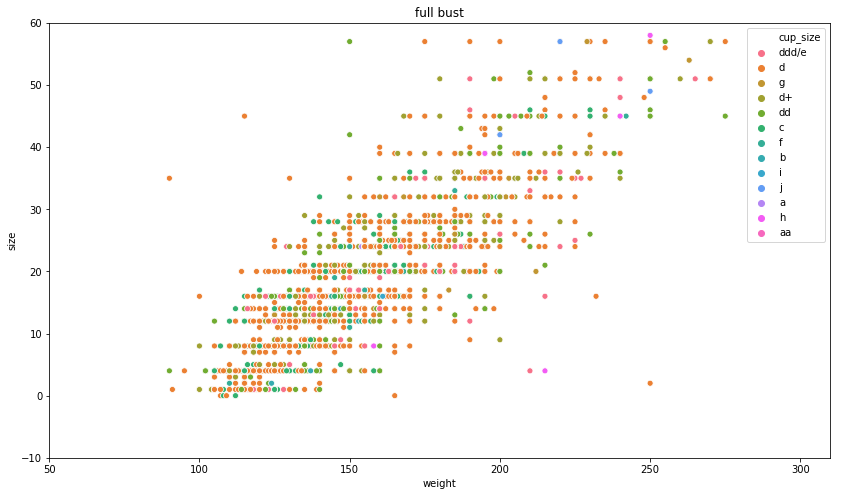

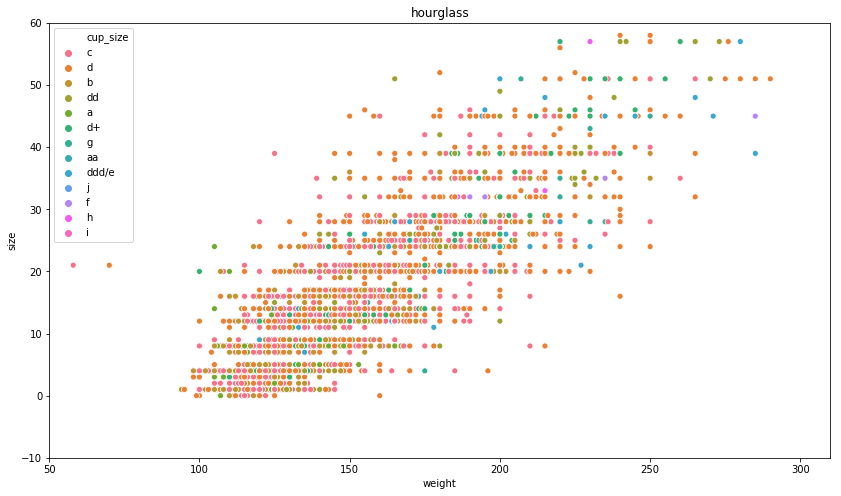

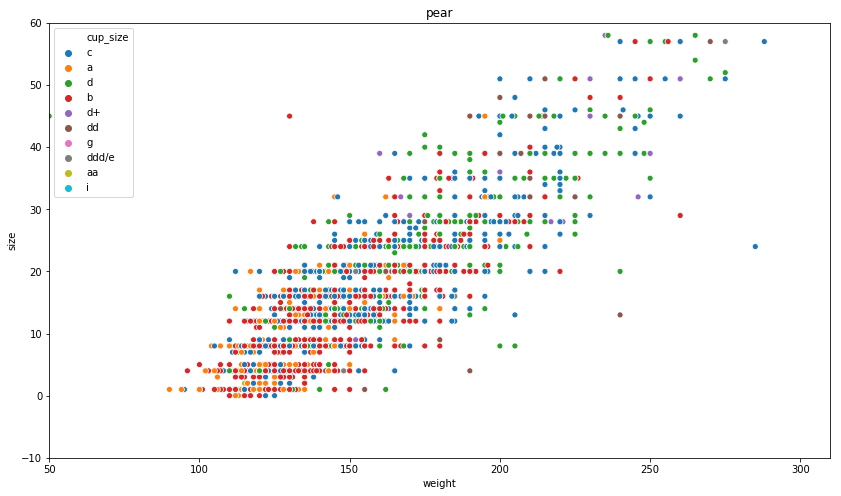

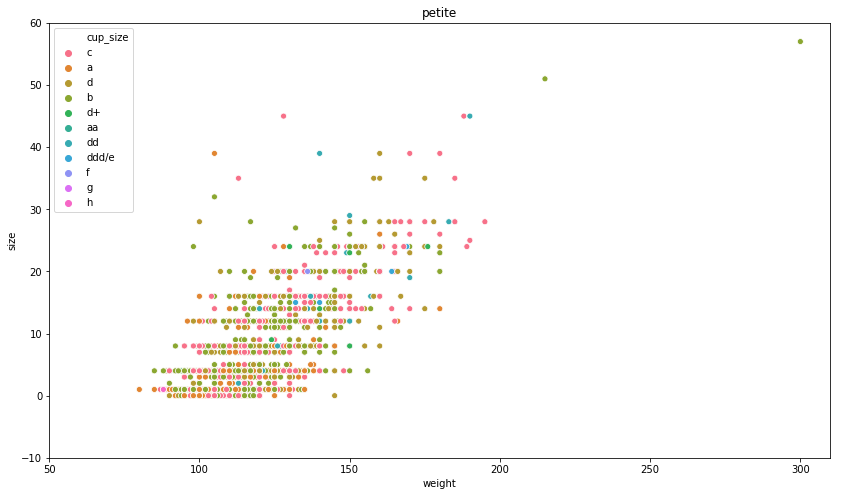

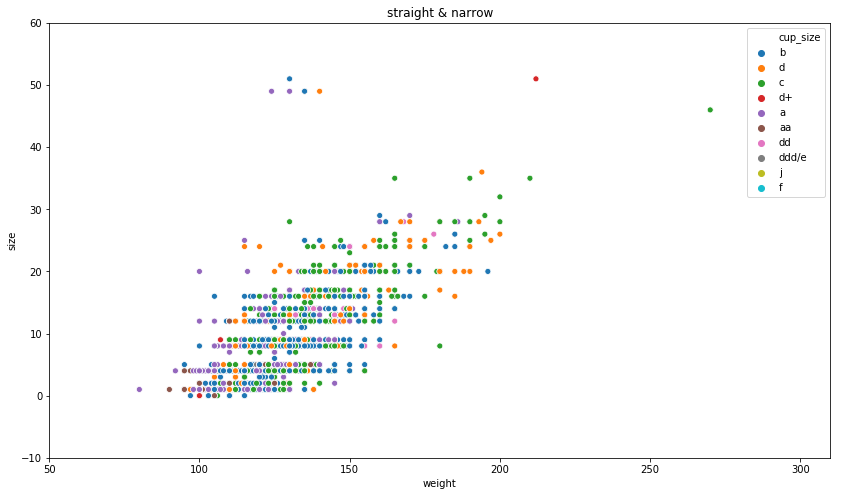

In [29]:
for bodytype in rtr_body_types:
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x='weight', y='size', hue='cup_size', legend='brief', data=rtr_data.loc[rtr_data.body_type==bodytype].groupby('user_id').first())
    plt.title(bodytype)
    plt.xlim(50,310)
    plt.ylim(-10,60)
    plt.show()

***